# PyTorch: IBA (Per-Sample Bottleneck)

This notebook shows how to apply the Per-Sample Bottleneck to pretrained ImageNet models. 

Ensure that `./imagenet` points to your copy of the ImageNet dataset. 

You might want to create a symlink:

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
sys.path.append('/content/drive/MyDrive/Prak_MLMI')
sys.path.append('/content/drive/MyDrive')
sys.path.append('/content/drive/MyDrive/Prak_MLMI/model')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.patches as patches

In [ ]:
# to set you cuda device
%env CUDA_VISIBLE_DEVICES=0

%load_ext autoreload
%autoreload 2

import torch
import torchvision.models 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Normalize, Grayscale
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm_notebook
import json
from PIL import Image
import numpy as np
import sys

try:
    import IBA
except ModuleNotFoundError:
    sys.path.insert(0, '..')
    import IBA
  
from IBA.pytorch import IBA, tensor_to_np_img
from IBA.utils import plot_saliency_map

import cxr_dataset as CXR


env: CUDA_VISIBLE_DEVICES=0


In [ ]:
#!unzip "/content/drive/MyDrive/NIH_CXR14_Resized.zip" -d "/content/drive/MyDrive/NIH_CXR14_Resized"
%%capture
!unzip "/content/drive/MyDrive/NIH_CXR14_Resized.zip" -d /content/

## Loading Data and Model

In [ ]:
prak_dir = '/content/drive/MyDrive/Prak_MLMI'
imagenet_dir = '/content/drive/MyDrive/Prak_MLMI/imagenet'
PATH_TO_IMAGES = "/content/NIH small"
MODEL_PATH = prak_dir + '/model/results/checkpoint_best'
label_path = '/content/drive/MyDrive/Prak_MLMI/model/labels'

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(MODEL_PATH, map_location=dev)
model = checkpoint['model'].module
model.to(dev).eval()
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# load the data

# use imagenet mean,std for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': Compose([
        Resize(224),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean, std)
    ]),
    'val': Compose([
        Resize(224),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean, std)
    ]),
}


bounding_box_transform = CXR.RescaleBB(224, 1024)


 

In [ ]:
def get_label(LA):
    labels = {   
        'Atelectasis': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Cardiomegaly': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Effusion': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Infiltration': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Mass': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Nodule': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Pneumonia': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Pneumothorax': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Consolidation': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Edema': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Emphysema': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Fibrosis': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Pleural_Thickening': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Hernia': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    }

    return labels.get(LA, None)

In [ ]:
def model_loss_closure(input):
  loss = nn.BCEWithLogitsLoss()
  mse_loss = loss(model(input), torch.tensor(_label).view(1,-1).expand(10, -1).to(dev).float())
  return mse_loss

In [ ]:
%matplotlib inline

In [ ]:
def samples_display(LABEL, beta=6):



  dataset = CXR.CXRDataset(
      path_to_images=PATH_TO_IMAGES,
      fold='BBox',#fold='train'
      transform=data_transforms['train'],
      transform_bb=bounding_box_transform,
      fine_tune=False,
      label_path=label_path,
      finding=LABEL)  #finding=LABEL
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)
  global _label
  _label = get_label(LABEL)


  seed = np.random.randint(0, 1000000000)

  np.random.seed(seed)

  length = len(dataset)
  print("20 Ransom samples of "+LABEL+" from " + str(length) + " images")

  for sample_idx in np.random.choice(length, 20):  #change with dataset length
      iba = IBA(model.features.denseblock2)
      iba.reset_estimate()
      iba.estimate(model, dataloader, device=dev, n_samples=length, progbar=False) #change with dataset length
      img, target, idx, bbox = dataset[sample_idx]
      img = img[None].to(dev)
  
      # reverse the data pre-processing for plotting the original image
      np_img = tensor_to_np_img(img[0])

      size = 4
      rows = 1
      cols = 5
      fig, (ax, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(cols*size, rows*size))


      cxr = img.data.cpu().numpy().squeeze().transpose(1, 2, 0)
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      cxr = std * cxr + mean
      cxr = np.clip(cxr, 0, 1)

  #    rect_original = patches.Rectangle((bbox[0, 0], bbox[0, 1]), bbox[0, 2], bbox[0, 3], linewidth=2, edgecolor='r', facecolor='none', zorder=2)
      rect_original = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none', zorder=2)

      ax.imshow(cxr)
      ax.axis('off')
      ax.set_title(idx)
      ax.add_patch(rect_original) 


      iba.reverse_lambda = False
      iba.beta = beta
      heatmap = iba.analyze(img, model_loss_closure) 
      # show the heatmap
      ax2 = plot_saliency_map(heatmap, np_img, ax=ax2)
      _ = ax2.set_title("Old method, Block2")
      ax2.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none', zorder=2))


      iba.reverse_lambda = True
      iba.beta = beta
      heatmap = iba.analyze(img, model_loss_closure) 
      # show the heatmap
      ax3 = plot_saliency_map(heatmap, np_img, ax=ax3)
      _ = ax3.set_title("New method, Block2")
      ax3.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none', zorder=2))


      iba = IBA(model.features.denseblock3)
      iba.reset_estimate()
      iba.estimate(model, dataloader, device=dev, n_samples=length, progbar=False)
      
      iba.reverse_lambda = False
      iba.beta = beta
      heatmap = iba.analyze(img, model_loss_closure) 
      # show the heatmap
      ax4 = plot_saliency_map(heatmap, np_img, ax=ax4)
      _ = ax4.set_title("Old method, Block3")
      ax4.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none', zorder=2))


      iba.reverse_lambda = True
      iba.beta = beta
      heatmap = iba.analyze(img, model_loss_closure) 
      # show the heatmap
      ax5 = plot_saliency_map(heatmap, np_img, ax=ax5)
      _ = ax5.set_title("New method, Block3")
      ax5.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none', zorder=2))



      plt.show()
  return length      


# Cardiomegaly

In [ ]:
LABEL='Cardiomegaly'

length_data=samples_display(LABEL)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
dataset = CXR.CXRDataset(
    path_to_images=PATH_TO_IMAGES,
    fold='BBox',#fold='train'
    transform=data_transforms['train'],
    transform_bb=bounding_box_transform,
    fine_tune=False,
    label_path=label_path,
    finding=LABEL)  #finding=LABEL
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)
img, target, idx, bbox = dataset[0]

## Compare different betas (So I chose beta=6 instead of 10, the default)

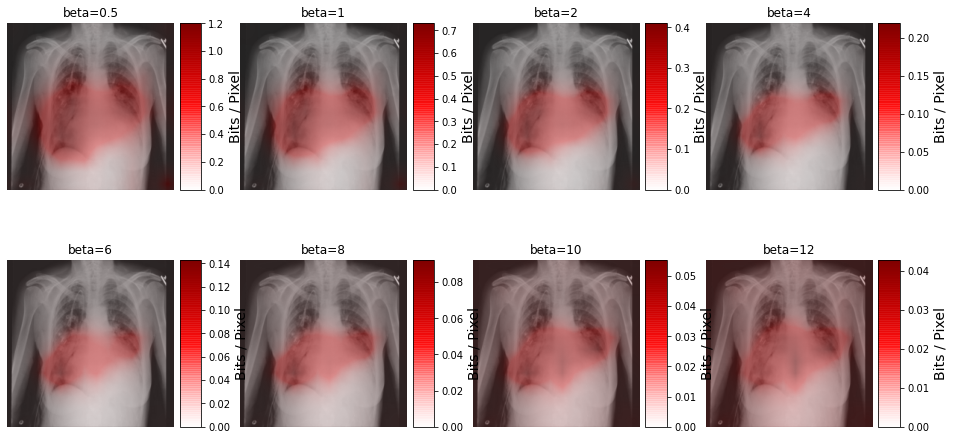

In [ ]:
iba = IBA(model.features.denseblock3)
iba.reset_estimate()
iba.estimate(model, dataloader, device=dev, n_samples=len(dataset), progbar=False)

size = 4
rows = 2
cols = 4
fig, axes = plt.subplots(2, 4, figsize=(cols*size, rows*size))

beta_set = [0.5, 1, 2, 4, 6, 8, 10, 12]
for beta_value, ax in zip(beta_set, axes.flatten()) : 
    heatmap = iba.analyze(img[None].to(dev), model_loss_closure, beta = beta_value) 
    ax = plot_saliency_map(heatmap, tensor_to_np_img(img), ax=ax)
    ax.set_title("beta={}".format(beta_value))
plt.show()

## Compare New and Old method with IB in output of denseblock3 with another image as well as compare masked and unmasked prediction probability

Old method
tensor([[0.0687, 0.4602, 0.5317, 0.4810, 0.0798, 0.0679, 0.0543, 0.0358, 0.1668,
         0.1442, 0.0067, 0.0084, 0.0370, 0.0024]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
tensor([[0.0414, 0.7961, 0.1009, 0.1522, 0.0023, 0.0117, 0.0106, 0.0048, 0.0257,
         0.0163, 0.0019, 0.0151, 0.0126, 0.0047]], device='cuda:0',
       grad_fn=<SigmoidBackward>)


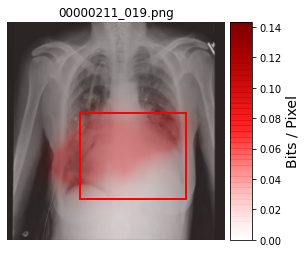

Ground truth with bounding box


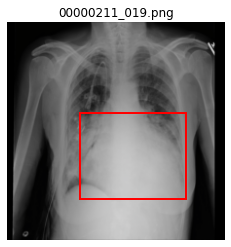

New method
tensor([[0.0687, 0.4602, 0.5317, 0.4810, 0.0798, 0.0679, 0.0543, 0.0358, 0.1668,
         0.1442, 0.0067, 0.0084, 0.0370, 0.0024]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
tensor([[0.1570, 0.1802, 0.5969, 0.5881, 0.1781, 0.1107, 0.0970, 0.0726, 0.2487,
         0.2412, 0.0141, 0.0155, 0.0766, 0.0055]], device='cuda:0',
       grad_fn=<SigmoidBackward>)


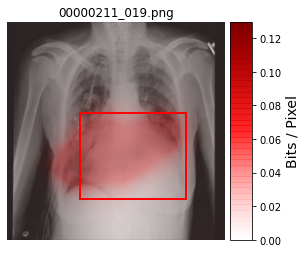

In [ ]:
img = img[None].to(dev)
np_img = tensor_to_np_img(img[0])
    
iba = IBA(model.features.denseblock3)
iba.reset_estimate()
iba.estimate(model, dataloader, device=dev, n_samples=length_data, progbar=False)


print("Old method")
iba.reverse_lambda = False
iba.beta = 6
#model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
heatmap = iba.analyze(img, model_loss_closure)  
# show the heatmap
ax = plot_saliency_map(heatmap, np_img)
_ = ax.set_title(idx)
ax.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none', zorder=2))

# show the prediction probability
print(torch.sigmoid(model(img)))
print(torch.tensor(_label).view(1,-1).to(dev).float())
with iba.restrict_flow():
  print(torch.sigmoid(model(img)))

plt.show()



print("Ground truth with bounding box")
cxr = img.data.cpu().numpy().squeeze().transpose(1, 2, 0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
cxr = std * cxr + mean
cxr = np.clip(cxr, 0, 1)

# rect_original = patches.Rectangle((bbox[0, 0], bbox[0, 1]), bbox[0, 2], bbox[0, 3], linewidth=2, edgecolor='r', facecolor='none', zorder=2)
rect_original = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none', zorder=2)

fig, ax2 = plt.subplots(1, 1, figsize=(5.5, 4.0))

ax2.imshow(cxr)
ax2.axis('off')
ax2.set_title(idx)
ax2.add_patch(rect_original) 
plt.show()

print("New method")
iba.reverse_lambda = True
iba.beta = 6
#model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
heatmap = iba.analyze(img, model_loss_closure) 
# show the heatmap
ax3 = plot_saliency_map(heatmap, np_img)
_ = ax3.set_title(idx)
ax3.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none', zorder=2))
# show the prediction probability
print(torch.sigmoid(model(img)))
print(torch.tensor(_label).view(1,-1).to(dev).float())
with iba.restrict_flow():
  print(torch.sigmoid(model(img)))
plt.show()

## Old method (try with different blocks of DenseNet) with other images


In [ ]:
def compare_blocks(length, ind=0):

  index = min (ind, length) 
  print("results for image "+str(index))
  img, target, idx, bbox = dataset[index]

  img = img[None].to(dev)
  np_img = tensor_to_np_img(img[0])

  size = 4
  rows = 1
  cols = 4
  fig, axes = plt.subplots(1, 4, figsize=(cols*size, rows*size))

  positions = [["1"], ["2"], ["3"],["4"]]

  for position, ax in zip(positions, axes.flatten()):
      current_pos = "model.features.denseblock{0}".format(*position)
      iba = IBA(eval(current_pos))
      iba.reset_estimate()
      iba.estimate(model, dataloader, device=dev, n_samples=length_data, progbar=False)

      iba.beta = 6
      heatmap = iba.analyze(img, model_loss_closure)
      ax = plot_saliency_map(heatmap, np_img, ax=ax)  
      ax.set_title(current_pos)
      ax.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none', zorder=2))

  plt.show()

results for image 0


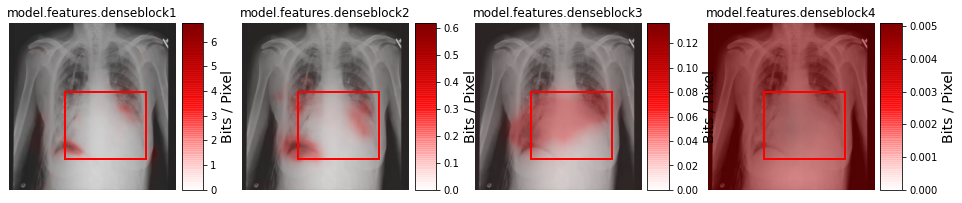

results for image 1


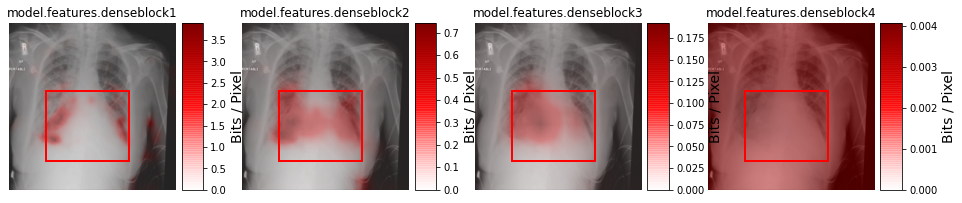

results for image 2


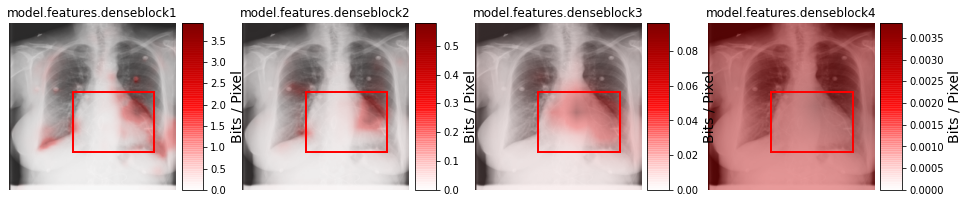

In [ ]:
compare_blocks(length_data,0)
compare_blocks(length_data,1)
compare_blocks(length_data,2)

# Atelectasis

In [ ]:
LABEL='Atelectasis'

length_data=samples_display(LABEL)

Output hidden; open in https://colab.research.google.com to view.

# Effusion

In [ ]:
LABEL='Effusion'
length_data=samples_display(LABEL)

Output hidden; open in https://colab.research.google.com to view.

# Mass

In [ ]:
LABEL='Mass'
length_data=samples_display(LABEL)

Output hidden; open in https://colab.research.google.com to view.

# Nodule

In [ ]:
LABEL='Nodule'
length_data=samples_display(LABEL)

Output hidden; open in https://colab.research.google.com to view.